# (Wang, 2000) Working memory model

Implementation of the paper: *Compte, Albert, et al. "Synaptic mechanisms and network dynamics underlying spatial working memory in a cortical network model." Cerebral cortex 10.9 (2000): 910-923.*

We modify the parameter J+ to reproduce results reported by the original paper.

- Author : Xinyu Liu
- Contact: adaliu1998@163.com

In [1]:
import brainpy as bp
import numpy as np
import brainmodels
import matplotlib.pyplot as plt
import math
from scipy.special import erf

In [2]:
def rotate_distance(x, y):
    dist = np.abs(x - y)
    return min(dist, 360 - dist)

In [3]:
# set params
## set global params
dt=0.1
bp.backend.set('numpy', dt=dt)

base_N_E = 2048
base_N_I = 512
net_scale = 8
N_E = base_N_E//net_scale
N_I = base_N_I//net_scale
time_scale = 10.
pre_period = 1000. / time_scale
cue_period = 250.
delay_period = 8750. / time_scale
resp_period = 250.
post_period = 1000. / time_scale
dist_period = 250.
total_period = pre_period + cue_period \
               + delay_period + resp_period \
               + post_period

In [4]:
## set neuron params
### E-neurons/pyramidal cells
C_E = 0.5          #nF
g_E = 25. * 1e-3   #uS
R_E = 1/g_E        #MOhm
tau_E = R_E * C_E  #ms
V_rest_E = -70.    #mV
V_reset_E = -60.   #mV
V_th_E = -50.      #mV
t_refractory_E = 2.#ms
### I-neurons/interneurons
C_I = 0.2          #nF
g_I = 20. * 1e-3   #uS
R_I = 1/g_I        #MOhm
tau_I = R_I * C_I  #ms
V_rest_I = -70.    #mV
V_reset_I = -60.   #mV
V_th_I = -50.      #mV
t_refractory_I = 1.#ms

class LIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, t, I_ext, V_rest, R, tau):
        dvdt = (- (V - V_rest) + R * I_ext) / tau
        return dvdt

    def __init__(self, size, V_rest=0., V_reset=0.,
                 V_th=0., R=0., tau=0., t_refractory=0.,
                 **kwargs):
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.R = R
        self.tau = tau
        self.t_refractory = t_refractory

        self.V = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size, dtype=bool)
        self.refractory = bp.ops.zeros(size, dtype=bool)
        self.t_last_spike = bp.ops.ones(size) * -1e7

        self.integral = bp.odeint(self.derivative)
        super(LIF, self).__init__(size=size, **kwargs)

    def update(self, _t):
        # update variables
        not_ref = (_t - self.t_last_spike > self.t_refractory)
        self.V[not_ref] = self.integral(
            self.V[not_ref], _t, self.input[not_ref],
            self.V_rest, self.R, self.tau)
        sp = (self.V > self.V_th)
        self.V[sp] = self.V_reset
        self.t_last_spike[sp] = _t
        self.spike = sp
        self.refractory = ~not_ref
        self.input[:] = 0.

In [5]:
## set input params
poission_frequency = 1800
g_max_input2E = 3.1 * 1e-3      #uS  #AMPA
g_max_input2I = 2.38 * 1e-3     #uS  #AMPA

class PoissonInput(bp.NeuGroup):
    target_backend='general'
    
    def __init__(self, size, freqs, dt, **kwargs):
        self.freqs = freqs
        self.dt = dt
        
        self.spike = bp.ops.zeros(size, dtype=bool)

        super(PoissonInput, self).__init__(size=size, **kwargs)
    
    def update(self, _t):
        self.spike = np.random.random(self.size) < self.freqs * self.dt / 1000.

In [6]:
## set synapse params
### AMPA
tau_AMPA = 2.  #ms
E_AMPA = 0.    #mV
### GABAa
tau_GABAa = 10. #ms
E_GABAa = -70.  #mV
### NMDA
tau_decay_NMDA = 100. #ms
tau_rise_NMDA = 2.    #ms
cc_Mg_NMDA = 1.       #mM
alpha_NMDA = 0.062    #/
beta_NMDA = 3.57      #/
a_NMDA = 0.5          #kHz
E_NMDA = 0.           #mV
g_max_E2E = 0.381 * 1e-3 * net_scale   #uS
g_max_E2I = 0.292 * 1e-3 * net_scale   #uS
g_max_I2E = 1.336 * 1e-3 * net_scale   #uS
g_max_I2I = 1.024 * 1e-3 * net_scale   #uS

class NMDA(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, x, t, tau_rise, tau_decay, a):
        dxdt = -x / tau_rise
        dsdt = -s / tau_decay + a * x * (1 - s)
        return dsdt, dxdt

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.15, E=0., cc_Mg=1.2,
                 alpha=0.062, beta=3.57, tau=100,
                 a=0.5, tau_rise=2., **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.cc_Mg = cc_Mg
        self.tau = tau
        self.tau_rise = tau_rise
        self.a = a
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.size)
        self.x = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.integral = bp.odeint(self.derivative)
        super(NMDA, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.x += bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.s, self.x = self.integral(self.s, self.x, _t,
                                       self.tau_rise, self.tau, self.a)

        self.g.push(self.g_max * self.s)
        g_inf = 1 + self.cc_Mg / self.beta * \
                bp.ops.exp(-self.alpha * self.post.V)
        g_inf = 1 / g_inf
        self.post.input -= bp.ops.sum(self.g.pull(), axis=0) * \
                           (self.post.V - self.E) * g_inf


class AMPA1(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, t, tau):
        ds = - s / tau
        return ds

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.10, E=0., tau=2.0, **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau = tau
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # data
        self.s = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.int_s = bp.odeint(f=self.derivative, method='euler')
        super(AMPA1, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.s = self.int_s(self.s, _t, self.tau)
        self.s += bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.g.push(self.g_max * self.s)
        self.post.input -= bp.ops.sum(self.g.pull(), 0) \
                           * (self.post.V - self.E)


class GABAa1(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, t, tau_decay):
        dsdt = - s / tau_decay
        return dsdt

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.4, E=-80., tau_decay=6.,
                 **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau_decay = tau_decay
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # data
        self.s = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.integral = bp.odeint(self.derivative)
        super(GABAa1, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.s = self.integral(self.s, _t, self.tau_decay)
        for i in range(self.pre.size[0]):
            if self.pre.spike[i] > 0:
                self.s[i] += self.conn_mat[i]
        self.g.push(self.g_max * self.s)
        g = self.g.pull()
        self.post.input -= bp.ops.sum(g, axis=0) \
                           * (self.post.V - self.E)

In [7]:
## set stimulus params
### cue
cue_angle = 160.
cue_width = 36.
cue_amp = 0.15   #nA(10^-9)
cue_idx = N_E * (cue_angle / 360.)
cue_idx_neg = int(N_E * ((cue_angle-(cue_width/2)) / 360.))
cue_idx_pos = int(N_E * ((cue_angle+(cue_width/2)) / 360.))
# here: may cause bug when idx go pass 360.
### distarctor
dist_angle = 30.
dist_width = 36.
dist_amp = cue_amp  #nA(10^-9)  # distractor stimulation always equal to cue stimulation
dist_idx = N_E * (dist_angle / 360.)
dist_idx_neg = int(N_E * ((dist_angle-(dist_width/2)) / 360.))
dist_idx_pos = int(N_E * ((dist_angle+(dist_width/2)) / 360.))
### response
resp_amp = 0.5  #nA(10^-9)

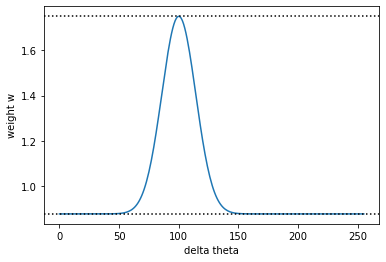

Check constraints:  255.99999999999994 should be equal to  256


In [8]:
# define weight
## structured weight
prefer_cue_E = np.linspace(0, 360, N_E+1)[:-1]
prefer_cue_I = np.linspace(0, 360, N_I+1)[:-1]
delta_E2E = 20.
J_plus_E2E = 1.75  #origin-1.62
tmp = math.sqrt(2. * math.pi) * delta_E2E * erf(180. / math.sqrt(2.) / delta_E2E) / 360.
J_neg_E2E = (1. - J_plus_E2E * tmp) / (1. - tmp)
JE2E = []
for i in range(N_E**2):
    JE2E.append(J_neg_E2E + 
                (J_plus_E2E - J_neg_E2E) * 
                np.exp(- 0.5 * rotate_distance(prefer_cue_E[i//N_E], prefer_cue_E[i%N_E])**2/delta_E2E ** 2))
JE2E = np.array(JE2E)

### visualize w-delta_theta plot
plt.plot(range(0, N_E), JE2E.reshape((N_E, N_E))[100])
plt.xlabel("delta theta")
plt.ylabel("weight w")
plt.axhline(y = J_plus_E2E, ls = ":", c = "k", label = "J+")
plt.axhline(y = J_neg_E2E, ls = ":", c = "k", label = "J-")
plt.show()
print("Check constraints: ", JE2E.reshape((N_E, N_E)).sum(axis=0)[0], "should be equal to ", N_E)
for i in range(N_E):
    JE2E[i*N_E + i] = 0.
JE2E = JE2E.reshape((N_E, N_E))  #for matrix mode

## unstructured weights
JE2I = 1.
JI2E = 1.
JI2I = np.full((N_I ** 2), 1. )
for i in range(N_I):
    JI2I[i*N_I + i] = 0.
JI2I = JI2I.reshape((N_I, N_I))  #for matrix mode

In [9]:
def create_input(cue_angle, cue_width, cue_amp,
                 dist_angle, dist_width, dist_amp,
                 resp_amp
                 ):
    ## build input (with stimulus in cue period and response period)
    input_cue , _  = bp.inputs.constant_current(
        [(0., pre_period), 
         (cue_amp, cue_period), 
         (0., delay_period), 
         (0., resp_period), 
         (0., post_period)])
    input_resp, _ = bp.inputs.constant_current(
        [(0., pre_period), 
         (0., cue_period), 
         (0., delay_period), 
         (resp_amp, resp_period), 
         (0., post_period)])
    input_dist, _ = bp.inputs.constant_current(
        [(0., pre_period), 
         (0., cue_period), 
         (0., (delay_period-dist_period)/2), 
         (dist_amp, cue_period), 
         (0., (delay_period-dist_period)/2), 
         (0., resp_period), 
         (0., post_period)])
    ext_input = input_resp
    for i in range(1, N_E):
        input_pos = input_resp
        if i >= cue_idx_neg and i <= cue_idx_pos:
            input_pos = input_pos + input_cue
        if i >= dist_idx_neg and i <= dist_idx_pos:
            input_pos = input_pos + input_dist
        ext_input = np.vstack((ext_input, input_pos))
    
    return ext_input.T

In [10]:
def run_simulation(input = None):
    # build neuron groups
    neu_E = LIF(N_E, monitors = ['V', 'spike', 'input'])
    neu_E.V_rest = V_rest_E
    neu_E.V_reset = V_reset_E
    neu_E.V_th = V_th_E
    neu_E.R = R_E
    neu_E.tau = tau_E
    neu_E.t_refractory = t_refractory_E
    neu_I = LIF(N_I, monitors = ['V', 'input'])
    neu_I.V_rest = V_rest_I
    neu_I.V_reset = V_reset_I
    neu_I.V_th = V_th_I
    neu_I.R = R_I
    neu_I.tau = tau_I
    neu_I.t_refractory = t_refractory_I

    # build synapse connections                 
    syn_E2E = NMDA(pre = neu_E, post = neu_E, conn = bp.connect.All2All())
    syn_E2E.g_max = g_max_E2E * JE2E

    syn_E2I = NMDA(pre = neu_E, post = neu_I, conn = bp.connect.All2All())
    syn_E2I.g_max = g_max_E2I * JE2I

    syn_I2E = GABAa1(pre = neu_I, post = neu_E, conn = bp.connect.All2All())
    syn_I2E.tau_decay = tau_GABAa
    syn_I2E.E = E_GABAa
    syn_I2E.g_max = g_max_I2E * JI2E

    syn_I2I = GABAa1(pre = neu_I, post = neu_I, conn = bp.connect.All2All())
    syn_I2I.tau_decay = tau_GABAa
    syn_I2I.E = E_GABAa
    syn_I2I.g_max = g_max_I2I * JI2I
    
    # set 1800Hz background input
    neu_input_E = PoissonInput(N_E, freqs = poission_frequency, dt=dt)
    syn_input2E = AMPA1(
        pre = neu_input_E,
        post = neu_E,
        conn=bp.connect.One2One(), 
        delay=0.)
    syn_input2E.tau_decay = tau_AMPA
    syn_input2E.E = E_AMPA
    syn_input2E.g_max = g_max_input2E
    
    neu_input_I = PoissonInput(N_I, freqs = poission_frequency, dt=dt)
    syn_input2I = AMPA1(
        pre = neu_input_I,
        post = neu_I,
        conn=bp.connect.One2One(), 
        delay=0.)
    syn_input2I.tau_decay = tau_AMPA
    syn_input2I.E = E_AMPA
    syn_input2I.g_max = g_max_input2I

    net = bp.Network(
        neu_input_E, neu_input_I, 
        syn_input2E, syn_input2I, 
        neu_E, neu_I, 
        syn_E2E, syn_E2I, 
        syn_I2E, syn_I2I)

    # run
    net.run(duration=total_period, 
            inputs = (
                      [neu_E, 'input', input, "+"]
                     ),
            report = False)
            
    # visualize
    print("ploting raster plot for simulation...")
    fig, gs = bp.visualize.get_figure(1, 1, 4, 10)

    fig.add_subplot(gs[0, 0])
    bp.visualize.raster_plot(net.ts, neu_E.mon.spike, xlim=(0., total_period), markersize=1)

    plt.show()

ploting raster plot for simulation...


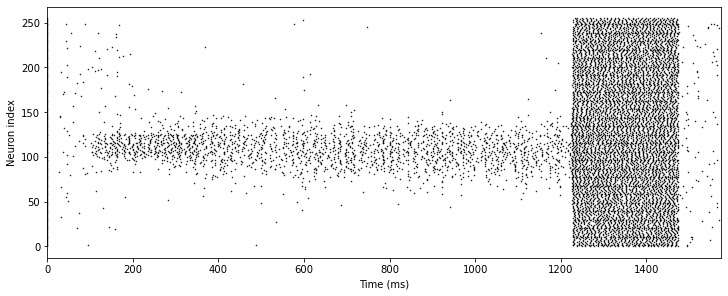

ploting raster plot for simulation...


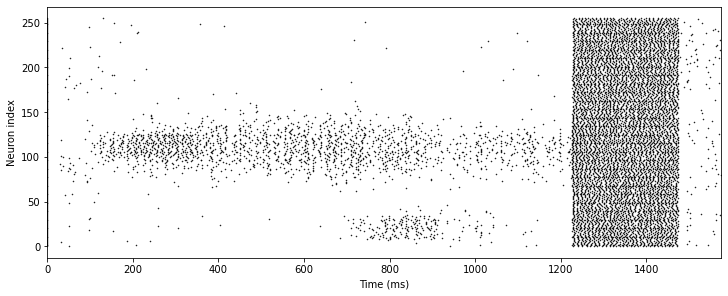

In [11]:
# simulate without distractor
ext_input = create_input(cue_angle = cue_angle, cue_width = cue_width, cue_amp = cue_amp,
                         dist_angle = 0., dist_width = 0., dist_amp = 0.,
                         resp_amp = resp_amp)
run_simulation(input = ext_input)

# simulate with distractor
ext_input = create_input(cue_angle = cue_angle, cue_width = cue_width, cue_amp = cue_amp,
                         dist_angle = dist_angle, dist_width = dist_width, dist_amp = dist_amp,
                         resp_amp = resp_amp)
run_simulation(input = ext_input)